In [16]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
import numpy as np
dcolors = plt.cm.tab10.colors
from pathlib import Path
import sys
sys.path.append('../../../code/')
import leakage
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import cm, colors
import matplotlib.lines as mlines
sns.set(font_scale = 1, style = 'ticks')
import reframed

# Figure 1A: metabolite time courses


In [10]:
git_folder = Path('../../..')
figure_folder = git_folder / 'Figures'

In [4]:
folder_paczia_ecoli = git_folder / 'data' / 'paczia_2012' / 'e_coli'
df_exometabolites, df_exometabolites_std = leakage.get_concentrations(folder_paczia_ecoli, 'e_coli')

In [5]:
fn_OD = folder_paczia_ecoli / 'e_coli_od.csv'
df_OD = pd.read_csv(fn_OD, index_col=0)

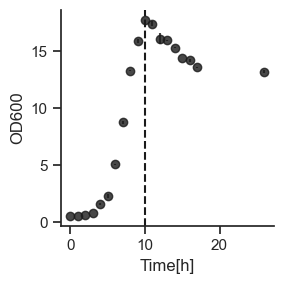

In [12]:
fig, ax = plt.subplots(1, figsize = (3,3))
plt.errorbar(df_OD.index, df_OD['OD mean'], yerr = df_OD['OD std'],  ls='none', marker = 'o', ms = 6, 
             color = 'k', alpha = 0.8)
plt.xlabel('Time[h]')
plt.ylabel('OD600')
plt.axvline(10, ls = '--', c = 'k')
sns.despine()
plt.tight_layout()
plt.savefig(figure_folder / 'ecoli_od.pdf')

In [7]:
m_abbr_to_name = {
    'LEU': 'L-Leucine',
    'R5P': 'Ribose 5-phosphate',
    'PYR': 'Pyruvate'
}

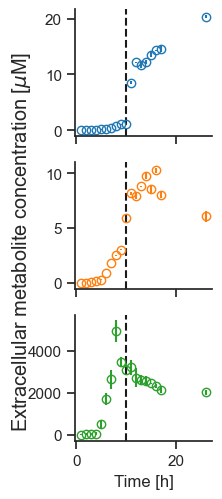

In [11]:
fig, axes = plt.subplots(3,1, figsize = (2.2,5), sharex=True)
for i, (abbr, name) in enumerate(m_abbr_to_name.items()):
    time = df_exometabolites.index
    conc = df_exometabolites[abbr]
    conc_std = df_exometabolites_std[abbr]
    # ax.plot(prod_rates, growth_rates, color = colors[i], label = r_ex_name, lw = 2)
    # axes[i].errorbar(time, conc, yerr = conc_std, color = dcolors[i], ls='none', marker = 'o', 
    #                  ms = 4, alpha = 0.8)

    axes[i].errorbar(time, conc, yerr = conc_std, ls='none', marker = 'o', 
                 ms = 6, markerfacecolor = 'none', markeredgecolor = dcolors[i], ecolor = dcolors[i])#alpha = 0.8
    axes[i].axvline(10, ls = '--', c = 'k')
    plt.tight_layout()
fig.supylabel(r'Extracellular metabolite concentration [$\mu$M]', x = 0)
axes[i].set_xlabel('Time [h]', size = 12)
sns.despine()
plt.subplots_adjust(bottom = 0.1)
plt.savefig(figure_folder /'concentration_curves.pdf')

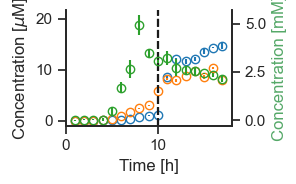

In [13]:
fig, ax1 = plt.subplots(1,1, figsize = (3,2))
ax2 = ax1.twinx()

for i, (abbr, name) in enumerate(m_abbr_to_name.items()):
    time = df_exometabolites.index
    conc = df_exometabolites[abbr]
    conc_std = df_exometabolites_std[abbr]
    # ax.plot(prod_rates, growth_rates, color = colors[i], label = r_ex_name, lw = 2)
    # axes[i].errorbar(time, conc, yerr = conc_std, color = dcolors[i], ls='none', marker = 'o', 
    #                  ms = 4, alpha = 0.8)
    if name =='Pyruvate':
        ax = ax2
        conc = conc*1e-3
        conc_std = conc_std*1e-3
    else:
        ax = ax1
    ax.errorbar(time, conc, yerr = conc_std, ls='none', marker = 'o', 
                 ms = 6, markerfacecolor = 'none', markeredgecolor = dcolors[i], ecolor = dcolors[i])#, alpha = 0.8)
    ax.axvline(10, ls = '--', c = 'k')
    plt.tight_layout()
# fig.supylabel(r'Extracellular metabolite concentration [$\mu$M]', x = 0)
plt.xlim(0, 18)
ax1.set_xlabel('Time [h]', size = 12)
ax1.set_ylabel(r'Concentration [$\mu$M]', size = 12)
ax2.set_ylabel(r'Concentration [mM]', size = 12, c = 'C2')
# plt.subplots_adjust(bottom = 0.1)
plt.tight_layout()
sns.despine(right = False)
plt.savefig(figure_folder / 'concentration_curves_2.pdf')

# Figure 1A: Production envelopes

In [102]:
model_fn = git_folder / 'models/e_coli/momentiJO1366_modified.xml'
# model = cobra.io.read_sbml_model(model_fn)
model = reframed.load_cbmodel(model_fn)
model.solver = 'gurobi'
glucose_uptake = -7.04

In [103]:
sol = reframed.FBA(model, constraints={'R_EX_glc__D_e':glucose_uptake})

In [104]:
def make_flux_envelope(model, met_id, nx = 20):
    r_str = f'R_temp_sink: {met_id} <->  [0,1000]'
    model.add_reaction_from_str(r_str)
    sol1 = reframed.FBA(model, constraints={'R_EX_glc__D_e':glucose_uptake}, objective='R_temp_sink')
    max_prod = sol1.fobj
    print(met_id, max_prod)
    prod_rates = np.linspace(0, max_prod, nx, endpoint=True)
    growth_rates = np.zeros(nx)
    for i, p in enumerate(prod_rates):
        soli = reframed.FBA(model, objective=model.biomass_reaction, 
                            constraints={'R_EX_glc__D_e':glucose_uptake, 'R_temp_sink':(p,p*1.00001)})
        growth_rates[i] = soli.fobj
    return growth_rates, prod_rates

In [105]:
sol.show_values('R_EX')

R_EX_ca2_e   -0.00325577
R_EX_cl_e    -0.00325577
R_EX_co2_e    16.5639
R_EX_cobalt2_e -1.56377e-05
R_EX_cu2_e   -0.000443486
R_EX_fe2_e   -0.0100463
R_EX_glc__D_e -7.04
R_EX_h_e      5.74732
R_EX_h2o_e    33.0834
R_EX_k_e     -0.122095
R_EX_meoh_e   1.25102e-06
R_EX_mg2_e   -0.00542629
R_EX_mn2_e   -0.000432227
R_EX_mobd_e  -8.06906e-05
R_EX_nh4_e   -6.75601
R_EX_ni2_e   -0.000202039
R_EX_o2_e    -15.2291
R_EX_pi_e    -0.603385
R_EX_so4_e   -0.15776
R_EX_zn2_e   -0.000213299


M_leu__L_c 2.587613295632955
M_r5p_c 7.720000000000001
M_pyr_c 16.083125000000003


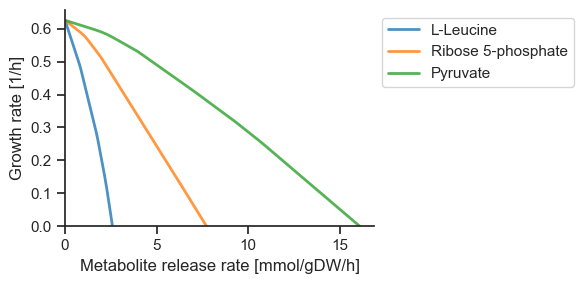

In [106]:

m_id_to_name = {
    'M_leu__L_c': 'L-Leucine',
    'M_r5p_c': 'Ribose 5-phosphate',
    'M_pyr_c': 'Pyruvate'
}
# sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, figsize = (6,3))
for i, (met_id, met_name) in enumerate(m_id_to_name.items()):
    growth_rates, prod_rates = make_flux_envelope(model, met_id, nx = 50)
    ax.plot(prod_rates, growth_rates, color = dcolors[i], label = met_name, lw = 2, alpha = 0.8)

n_above = np.sum(growth_rates>growth_rates[0]*0.8)
# ax.axhline(growth_rates[0]*0.9, ls = '--', c = 'k', label = 'Suboptimal threshold')
x = np.linspace(0, prod_rates[n_above-1], n_above)
# ax.plot(x, np.ones(n_above)*growth_rates[0]*0.9, ls = '--', c = 'k', label = 'Suboptimal threshold')
# ax.fill_between(x, np.ones(n_above)*growth_rates[0]*0.8, growth_rates[:n_above],
#                 alpha = 0.7, color = 'lightgray', label = 'Suboptimal region', zorder = 0)
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_ylabel('Growth rate [1/h]')
ax.set_xlabel('Metabolite release rate [mmol/gDW/h]')
sns.despine()
plt.tight_layout()
plt.savefig(figure_folder / '1B_production_envelope_raw_no_suboptimal_region.pdf')


# Figure 1B: Rate estimations
See notebook 2B

# Figure 1C: Plot leakage rates
Plot leakage rates release rates and metabolite values. Estimated from batch cultures in this project, Paczia et al., 2012 and Vila et al. 2023